#Mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install pytorch

In [ ]:
!pip install -q torch torchvision
!pip install -q cityscapesscripts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00


#Define ICNET model

##Implement Max Attention Supression and Random Attention Dropout to increase robustness

In [ ]:
import torch
import torch.nn.functional as F

def max_attention_suppression(A, N, T, threshold=0.8):
    """
    Apply Max Attention Suppression (MAS) to the attention map A.

    meaning of arguments:
        A (torch.Tensor): Input attention map or logits (shape: [B, C, H, W]).
        N (int): Total number of classes or features.
        T (float): Temperature parameter for sharpness control (0 < T < 1).
        threshold (float): Clipping threshold to suppress excessive attention values.
        the threshold allows the model to become more robust (smaller values), or less robust (larger values).
        the tradeoff between robustness and generalization on clean data can be observed with different values.
    """
    # This is where the attention values are scaled and supressed for robustness
    A_prime = 0.5 * A * (1 + A.abs()) + torch.log(torch.tensor(N - 1, device=A.device)) * (T / (1 - T))

    # The threshold defines the max attention value the attention matrix can have (0.8 worked best for us, can be adjusted)
    A_prime = torch.clamp(A_prime, max=threshold)

    # Apply softmax to normalize attention values
    M = F.softmax(A_prime, dim=1)
    return M


In [ ]:
def random_attention_dropout(M, p=0.1, training=True):
    """
    This function defines the Random Attention Dropout (RAD) applied to the attention map.

      meaning of arguments:
        M (torch.Tensor): Attention map (shape: [B, C, H, W]).
        p (float): Dropout probability (0.1 was used in our case to avoid information loss)
        training (bool): We do NOT use RAD during evaluation of the model.
    """

    if training:
        M_prime = F.dropout(M, p=p, training=True)
    else:
        M_prime = M
    return M_prime

## Model architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50


# Defining the Pyramid Pooling class for ICNET (Adaptive Average 2D pooling)

class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6]):
        super(PyramidPooling, self).__init__()
        self.pools = nn.ModuleList([
            nn.AdaptiveAvgPool2d(output_size=size) for size in pool_sizes
        ])
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1, bias=False) for _ in pool_sizes
        ])
        out_channels = in_channels + (in_channels // len(pool_sizes)) * len(pool_sizes)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        size = x.shape[2:]
        out = [x]
        for pool, conv in zip(self.pools, self.convs):
            pooled = pool(x)
            conv_out = conv(pooled)
            out.append(F.interpolate(conv_out, size=size, mode='bilinear', align_corners=True))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


# Cascade Feature Fusion
class CascadeFeatureFusion(nn.Module):
    """CFF Unit"""
    def __init__(self, low_channels, high_channels, out_channels, n_classes):
        super(CascadeFeatureFusion, self).__init__()
        self.conv_low = nn.Sequential(
            nn.Conv2d(low_channels, out_channels, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_high = nn.Sequential(
            nn.Conv2d(high_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_low_cls = nn.Conv2d(out_channels, n_classes, kernel_size=1, bias=False)

    def forward(self, x_low, x_high):
        x_low = F.interpolate(x_low, size=x_high.shape[2:], mode='bilinear', align_corners=True)
        x_low = self.conv_low(x_low)
        x_high = self.conv_high(x_high)
        x = F.relu(x_low + x_high, inplace=True)
        x_low_cls = self.conv_low_cls(x_low)
        return x, x_low_cls


# Semantic Segmentation Model to be trained on 8 classes

class SemanticSegmentationModel(nn.Module):
    def __init__(self, n_classes=8):
        super(SemanticSegmentationModel, self).__init__()
        resnet = resnet50(weights='IMAGENET1K_V1')
        self.initial_layers = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.pyramid_pooling = PyramidPooling(2048)

        self.cff_24 = CascadeFeatureFusion(low_channels=4096, high_channels=1024, out_channels=512, n_classes=n_classes)
        self.cff_12 = CascadeFeatureFusion(low_channels=512, high_channels=512, out_channels=128, n_classes=n_classes)

        self.classifier = nn.Conv2d(128, n_classes, kernel_size=1)

    def forward(self, x, training=True):
        # ResNet Feature Extraction (pretrained backbone)
        x = self.initial_layers(x)
        c1 = self.layer1(x)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)

        # Apply Max Attention Suppression (MAS) (MAS is applied AFTER RESNET layers and before ICNET model)
        c4 = max_attention_suppression(c4, threshold=0.5)

        # Pyramid Pooling
        c4 = self.pyramid_pooling(c4)

        # Apply Random Attention Dropout (RAD) during training (RAD is performed after pyramid pooling )
        if training:
            c4 = random_attention_dropout(c4, p=0.1, training=training)

        # Cascade Feature Fusion
        c3_c4, aux_c3_c4 = self.cff_24(c4, c3)
        c1_c2_c3, aux_c1_c2 = self.cff_12(c3_c4, c2)

        # Final Classifier
        out = self.classifier(c1_c2_c3)

        # Upsample outputs to match original image size
        out = F.interpolate(out, size=(128, 256), mode='bilinear', align_corners=False)
        aux_c3_c4 = F.interpolate(aux_c3_c4, size=(128, 256), mode='bilinear', align_corners=False)
        aux_c1_c2 = F.interpolate(aux_c1_c2, size=(128, 256), mode='bilinear', align_corners=False)
        return out, aux_c3_c4, aux_c1_c2

#Fetch data for laoder

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import os

class CityscapesCustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, dataset_type="clean", transform=None):

        """
        Custom Cityscapes Dataset.
        - root_dir: Root directory of the dataset containing images and labels.
        - dataset_type: Either "clean" or "adversarial".
        - transform: Transformations to apply to images (labels remain untransformed).
        """

        self.root_dir = root_dir
        self.transform = transform


        if dataset_type == "clean":
            self.image_dir = os.path.join(root_dir, "Clean Images")
        elif dataset_type == "adversarial":
            self.image_dir = os.path.join(root_dir, "Adverserial Images")
        else:
            raise ValueError(f"Unknown dataset_type: {dataset_type}. Use 'clean' or 'adversarial'.")

        self.label_dir = os.path.join(root_dir, "Labels")  # Labels are shared

        # Get list of all images and corresponding labels
        self.image_paths = sorted(os.listdir(self.image_dir))
        self.label_paths = sorted(os.listdir(self.label_dir))

        # Ensure correspondence between images and labels
        assert len(self.image_paths) == len(self.label_paths), "Mismatch between images and labels"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and label
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])

        # Load image and label
        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)  # Labels are grayscale

        # Transformations are appllied to the image only (not to labels)
        if self.transform:
            image = self.transform(image)


        label = torch.tensor(np.array(label), dtype=torch.long)

        return image, label


#Make some transformations to the images and load them to a dataloader to store val and train data

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
import random
from torch.utils.data import ConcatDataset, random_split, Subset

# Define transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



root_dir = '/content/drive/MyDrive/Cityscapes/Final_Dataset'

clean_dataset = CityscapesCustomDataset(root_dir=root_dir, dataset_type="clean", transform=image_transform)
adv_dataset = CityscapesCustomDataset(root_dir=root_dir, dataset_type="adversarial", transform=image_transform)

# Combine datasets (clean and patched)
combined_dataset = ConcatDataset([clean_dataset, adv_dataset])

# Get indices of adversarial images in the combined dataset (to ensure val is only on patched images)
adv_indices = list(range(len(clean_dataset), len(combined_dataset)))

# Shuffle the adversarial indices
np.random.shuffle(adv_indices)

# Define the validation size
val_size = int(0.2 * len(combined_dataset))


val_indices = adv_indices[:val_size]


train_indices = list(set(range(len(combined_dataset))) - set(val_indices))


train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)



train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)

#Define progress bar

In [ ]:
!pip install tqdm

#Define function to calculate the MIoU

In [ ]:
import torch
import numpy as np

def calculate_iou(pred, target, num_classes):
    """
    Calculate IoU for each class over a batch.
    Args:
        pred: Predicted tensor of shape (batch_size, height, width)
        target: Ground truth tensor of shape (batch_size, height, width)
        num_classes: Total number of classes.
    Returns:
        miou: Mean IoU over all classes.
    """
    ious = []

    # Flatten predictions and targets across the batch
    pred = pred.view(-1)  # Shape: (batch_size * height * width)
    target = target.view(-1)  # Shape: (batch_size * height * width)

    for cls in range(num_classes):
        # True Positive (intersection)
        intersection = ((pred == cls) & (target == cls)).sum().item()
        # Union
        union = ((pred == cls) | (target == cls)).sum().item()

        if union == 0:
            ious.append(float('nan'))  # Ignore classes not present in the batch
        else:
            ious.append(intersection / union)

    # Calculate mean IoU, ignoring NaN values
    miou = np.nanmean(ious)
    return miou

#Define a train and validate function for the model to learn form the images in the dataloader

In [ ]:
def train(model, dataloader, criterion, optimizer, device, training=True, num_classes=8):
    model.train()
    total_loss = 0.0

    with tqdm(dataloader, desc="Training", leave=False) as pbar:
        for imgs, labels in pbar:
            # Move data to the device
            imgs, labels = imgs.to(device), labels.to(device, dtype=torch.long)

            # Mask out ignored regions (-1)
            valid_mask = labels >= 0  # Boolean mask for valid pixels
            labels = torch.where(valid_mask, labels, torch.zeros_like(labels))  # Replace -1 with 0 for loss computation

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(imgs, training=training)  # Pass `training` flag to model's forward method

            # Handle different output formats (e.g., tuple, dictionary, tensor)
            if isinstance(outputs, dict) and "out" in outputs:
                outputs = outputs["out"]
            elif isinstance(outputs, tuple):
                outputs = outputs[0]

            # Resize outputs to match labels
            if outputs.shape[-2:] != labels.shape[-2:]:
                outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)

            # Compute loss only on valid pixels
            loss = criterion(outputs, labels) * valid_mask.float()
            loss = loss.sum() / valid_mask.sum()  # Normalize by the number of valid pixels

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Track and log loss
            total_loss += loss.item()
            pbar.set_postfix({'Avg Loss': total_loss / (pbar.n + 1)})

    return total_loss / len(dataloader)


Create a validation function to validate the model on the validation set

In [ ]:
def validate(model, dataloader, criterion, device, num_classes=8, training=False):

    model.eval()
    total_loss = 0.0
    total_miou = 0.0

    with torch.no_grad():
        with tqdm(dataloader, desc="Validating", leave=False) as pbar:
            for imgs, labels in pbar:
                # Move data to the device
                imgs, labels = imgs.to(device), labels.to(device, dtype=torch.long)

                # Forward pass
                outputs = model(imgs, training=training)  # Pass `training` flag

                # Handle different output formats (e.g., tuple, dictionary, tensor)
                if isinstance(outputs, dict) and "out" in outputs:
                    outputs = outputs["out"]
                elif isinstance(outputs, tuple):
                    outputs = outputs[0]

                # Resize outputs to match labels
                if outputs.shape[-2:] != labels.shape[-2:]:
                    outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)

                # Compute loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                # Calculate mIoU
                preds = torch.argmax(outputs, dim=1)
                miou = calculate_iou(preds, labels, num_classes)
                total_miou += miou

                # Log metrics
                pbar.set_postfix({'Avg Loss': total_loss / (pbar.n + 1), 'Avg mIoU': total_miou / (pbar.n + 1)})

    avg_loss = total_loss / len(dataloader)
    avg_miou = total_miou / len(dataloader)
    return avg_loss, avg_miou


#Implement Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, save_path='best_model.pth'):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_score = None
        self.epochs_without_improvement = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        # If it's the first epoch, save the initial model
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        # Check if the current validation loss is better than the best score recorded
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.epochs_without_improvement = 0
            self.save_checkpoint(model)
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Save the model when validation loss decreases."""
        torch.save(model.state_dict(), self.save_path)
        print(f"Model improved")


#Train model and evaluate

In [ ]:
import torch
import random
import numpy as np
from tqdm import tqdm


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SemanticSegmentationModel().to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
miou_scores = []

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.001, save_path='best_model.pth')

num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")


    model.train()
    train_loss = train(model, train_loader, criterion, optimizer, device, training=True)
    train_losses.append(train_loss)


    model.eval()
    val_loss, val_miou = validate(model, val_loader, criterion, device, training=False)
    val_losses.append(val_loss)
    miou_scores.append(val_miou)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_miou:.4f}")


    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break


final_metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "miou_scores": miou_scores
}
torch.save(final_metrics, 'training_metrics.pth')

print("Training complete.")

Epoch 1/30


Train Loss: 0.4437 | Val Loss: 0.4008 | mIoU: 0.6034
Model improved
Epoch 2/30


Train Loss: 0.3724 | Val Loss: 0.3794 | mIoU: 0.6229
Model improved
Epoch 3/30


Train Loss: 0.3553 | Val Loss: 0.3929 | mIoU: 0.6066
Epoch 4/30


Train Loss: 0.3322 | Val Loss: 0.3901 | mIoU: 0.6211
Epoch 5/30


Train Loss: 0.3171 | Val Loss: 0.3232 | mIoU: 0.6539
Model improved
Epoch 6/30


Train Loss: 0.3072 | Val Loss: 0.6556 | mIoU: 0.5134
Epoch 7/30


Train Loss: 0.2946 | Val Loss: 0.3176 | mIoU: 0.6581
Model improved
Epoch 8/30


Train Loss: 0.2675 | Val Loss: 0.3036 | mIoU: 0.6624
Model improved
Epoch 9/30


Train Loss: 0.2798 | Val Loss: 0.4982 | mIoU: 0.5934
Epoch 10/30


Train Loss: 0.2828 | Val Loss: 0.2722 | mIoU: 0.6776
Model improved
Epoch 11/30


Train Loss: 0.2445 | Val Loss: 0.2708 | mIoU: 0.6769
Model improved
Epoch 12/30


Train Loss: 0.2435 | Val Loss: 0.4037 | mIoU: 0.6157
Epoch 13/30


Train Loss: 0.2406 | Val Loss: 0.2523 | mIoU: 0.6900
Model improved
Epoch 14/30


Train Loss: 0.2472 | Val Loss: 0.3041 | mIoU: 0.6627
Epoch 15/30


Train Loss: 0.2212 | Val Loss: 0.2388 | mIoU: 0.7033
Model improved
Epoch 16/30


Train Loss: 0.2073 | Val Loss: 0.2376 | mIoU: 0.7047
Model improved
Epoch 17/30


Train Loss: 0.2058 | Val Loss: 0.2861 | mIoU: 0.6847
Epoch 18/30


Train Loss: 0.2180 | Val Loss: 0.4212 | mIoU: 0.6285
Epoch 19/30


Train Loss: 0.2013 | Val Loss: 0.2222 | mIoU: 0.7128
Model improved
Epoch 20/30


Train Loss: 0.1892 | Val Loss: 0.2148 | mIoU: 0.7175
Model improved
Epoch 21/30


Train Loss: 0.1860 | Val Loss: 0.2194 | mIoU: 0.7139
Epoch 22/30


Train Loss: 0.1837 | Val Loss: 0.2698 | mIoU: 0.6954
Epoch 23/30


Train Loss: 0.2565 | Val Loss: 0.2965 | mIoU: 0.6613
Epoch 24/30


Train Loss: 0.2256 | Val Loss: 0.2270 | mIoU: 0.7135
Epoch 25/30


Train Loss: 0.1874 | Val Loss: 0.2115 | mIoU: 0.7233
Model improved
Epoch 26/30


Train Loss: 0.1759 | Val Loss: 0.2079 | mIoU: 0.7264
Model improved
Epoch 27/30


Train Loss: 0.1724 | Val Loss: 0.2070 | mIoU: 0.7256
Epoch 28/30


Train Loss: 0.1715 | Val Loss: 0.2067 | mIoU: 0.7284
Model improved
Epoch 29/30


Train Loss: 0.1700 | Val Loss: 0.2080 | mIoU: 0.7273
Epoch 30/30


Train Loss: 0.1695 | Val Loss: 0.2015 | mIoU: 0.7310
Model improved
Training complete.


#Vizualize the model's predictions

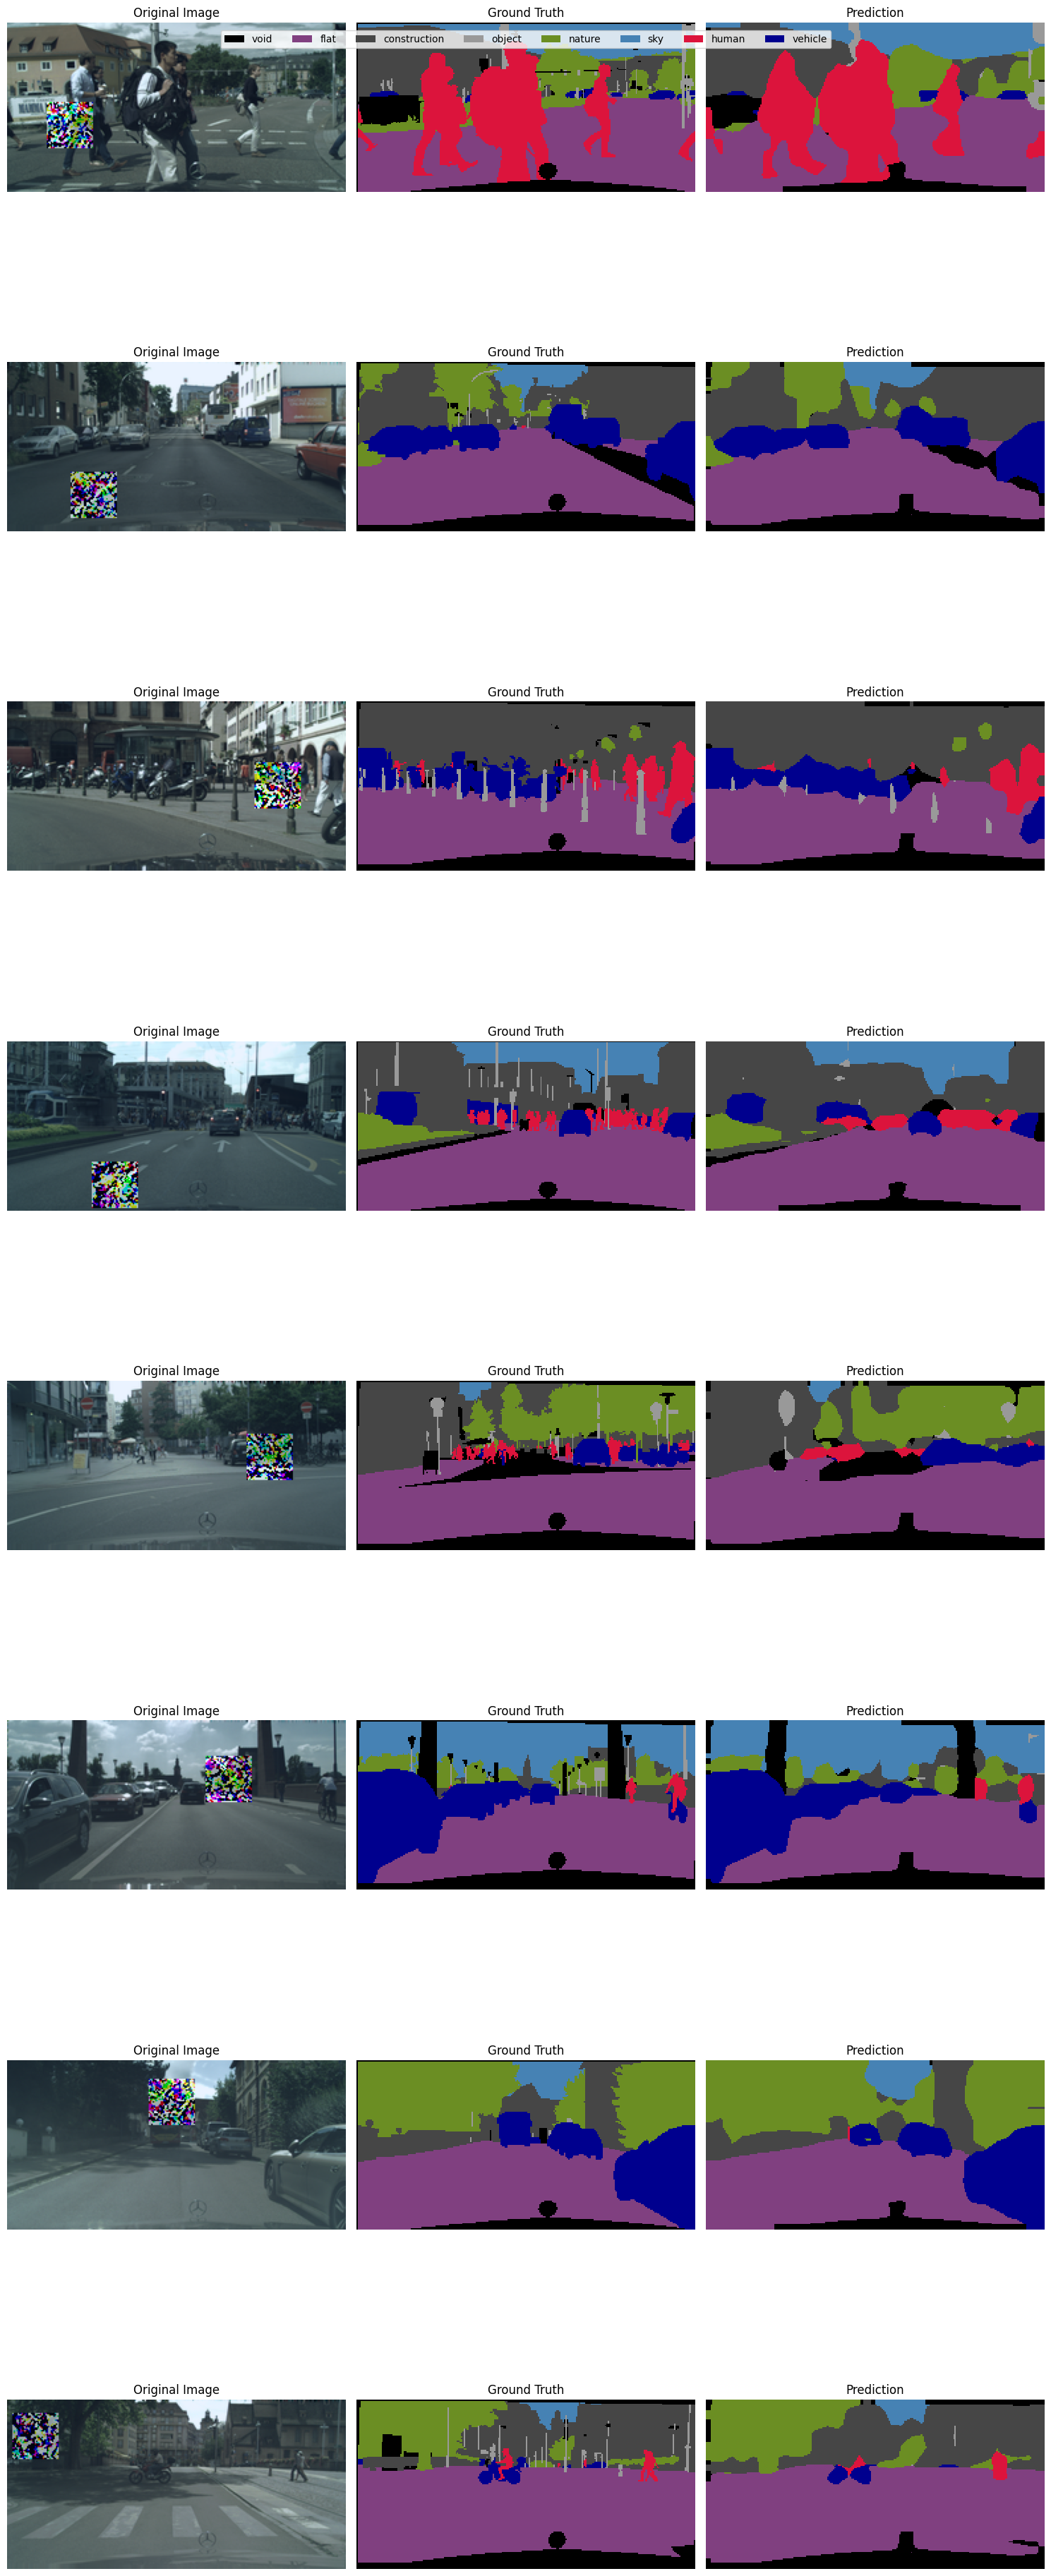

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import torch


def visualize_batch(images, labels, preds, class_colors, class_names=None):
    """
    Visualizes a batch of original images, target masks, and predicted masks.

    Args:
        images: Tensor of shape (batch_size, channels, height, width)
        labels: Tensor of shape (batch_size, height, width)
        preds: Tensor of shape (batch_size, height, width)
        class_colors: List of RGB tuples for each class.
        class_names: Optional list of class names for a legend.
    """
    batch_size = images.shape[0]

    # Create a color map for segmentation masks
    cmap = ListedColormap(np.array(class_colors) / 255.0)  # Normalize colors to [0, 1]

    # Create a grid of subplots: each row for one sample (original, ground truth, prediction)
    fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

    # If batch size is 1, adjust axes to avoid indexing issues
    if batch_size == 1:
        axes = axes[np.newaxis, :]

    for i in range(batch_size):
        # Convert image to numpy and normalize to [0, 1]
        img = images[i].permute(1, 2, 0).cpu().numpy()  # (height, width, channels)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization

        # Convert labels and predictions to numpy arrays
        label = labels[i].cpu().numpy()
        pred = preds[i].cpu().numpy()

        # Plot the original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Plot the ground truth with the colormap
        axes[i, 1].imshow(label, cmap=cmap, interpolation="nearest")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Plot the predictions with the colormap
        axes[i, 2].imshow(pred, cmap=cmap, interpolation="nearest")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    # Add a legend for class names if provided
    if class_names is not None:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=np.array(color) / 255.0, label=name)
            for color, name in zip(class_colors, class_names)
        ]
        fig.legend(
            handles=legend_elements,
            loc="upper center",
            ncol=len(class_names),
            bbox_to_anchor=(0.5, 0.95),
        )

    plt.tight_layout()
    plt.show()


# Example Usage:
# Assuming you have a DataLoader (`val_loader`) and a trained model
for images, labels in val_loader:
    # Move images and labels to the device (e.g., GPU)
    images = images.to(device)  # Shape: (batch_size, channels, height, width)
    labels = labels.to(device)  # Shape: (batch_size, height, width)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)[0]  # Outputs shape: (batch_size, num_classes, height, width)
        preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices

    # Define class colors (RGB tuples)
    class_colors = [
    (0, 0, 0),         # void: Black
    (128, 64, 128),    # flat (road, sidewalk): Purple
    (70, 70, 70),      # construction (building, wall): Dark gray
    (153, 153, 153),   # object (poles, signs): Light gray
    (107, 142, 35),    # nature (trees, vegetation): Green
    (70, 130, 180),    # sky: Light blue
    (220, 20, 60),     # human (pedestrians, cyclists): Red
    (0, 0, 142)        # vehicle: Dark blue
]

    # Define class names
    class_names = [
        "void",
        "flat",
        "construction",
        "object",
        "nature",
        "sky",
        "human",
        "vehicle",
    ]

    # Visualize the batch
    visualize_batch(images, labels, preds, class_colors, class_names)
    break  # Exit after visualizing the first batch


#Vizualize the convergance of the model

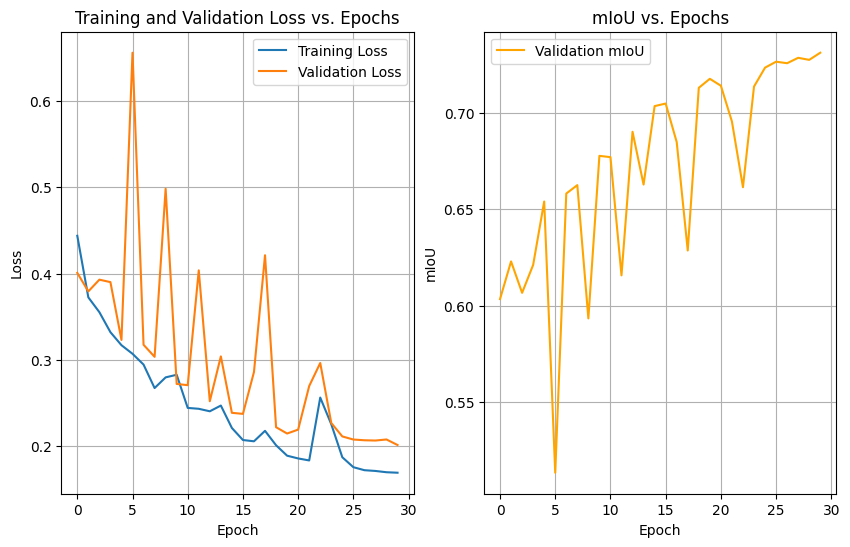

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Training and Validation Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plot mIoU vs. Epochs
plt.subplot(1,2,2)
plt.plot(miou_scores, label='Validation mIoU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('mIoU vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


The results from the loss curve show a decrease in training and validation, which would support the conclusion that the Robuist Attention Mechanism is effective in moderation. When we decrease the value of the threshold for Max Attention Supression (MAS) to values like 0.3,0.2. To supress the attention scores further, we notice that the model's ability to predict degrades quickly on both patched and clean images.